In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import image_helper as ih
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

Считываем все данные из файлов. Получаем словарь {'Название файла': {цвет:процент,цвет:процент}}. Предполагается что файлы с флагами находятся в папке Flags

In [2]:
fileDics = ih.GetFileDics()

/content/image_helper.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  totalPixels = np.array(internalDic)[:,0].sum()


Отбираем коды уникальных цветов (27), формируем матрицу признаков - Х. Заполняем по аналогии с OneHotEncoding. Если в экземпляре присутствует цвет - проставляем процент, который присутствует (в сотых долях - как считалось). Если цвет не присутствует - оставляем 0. Создаем и настраиваем алгоритм кластеризации

In [3]:
colors = set()
for fc in fileDics.values():
  for c in fc.keys():  
    colors.add(c)
print("Кол-во цветов:", len(colors))

colors=list(colors)
colors.sort()

X=list()
y=list()
fccopy=list()

for fc in fileDics.values():
  fccopy=list()
  for c in colors:
    if fc.get(c) == None:
      fccopy.append(0) 
    else:
      fccopy.append(fc[c])
  X.append(fccopy)
  fccopy=[]

for f in fileDics:
  y.append(f)

print(X)
print(y)

Кол-во цветов: 27
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0, 0.3333333333333333, 0, 0.3333333333333333], [0.022, 0.3, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.35686666666666667], [0, 0, 0, 0.6666666666666666, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333], [0.29444444444444445, 0, 0, 0.16111111111111112, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.29444444444444445, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2388888888888889], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9656, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5871604938271605, 0, 0, 0, 0, 0, 0, 0, 0.04975308641975309, 0, 0], [0.16296296296296298, 0, 0, 0.2898148148148148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2898148148148148, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25], [0, 0.3773170731707317, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.59707317

Для начала проверим работу KernelPCA

In [4]:
from sklearn.decomposition import PCA, KernelPCA

param_grid=[{"degree": [1,2,3,4],
             "gamma": [0.1, 0.5, 1, 2, 3],
             "kernel": ["poly","rbf","sigmoid"]}]

def my_scorer(estimator, X, y=None):
  X_reduced = estimator.transform(X)
  X_preimage = estimator.inverse_transform(X_reduced)
  return -1 * mean_squared_error(X, X_preimage)


grid_search = GridSearchCV(KernelPCA(fit_inverse_transform=True, n_jobs=-1, n_components=2) , param_grid, cv=3, scoring=my_scorer)
grid_search.fit(X)
X_transformed = grid_search.transform(X);
print("Лучшие параметры : " + str(grid_search.best_params_))

kpca = KernelPCA(n_components=2,degree=3, gamma=1, kernel="poly")
X_pca = kpca.fit_transform(X)
X_pca.shape

Лучшие параметры : {'degree': 3, 'gamma': 1, 'kernel': 'poly'}


(206, 2)

С помощью алгоритмов понижения размерности понизить размерность исходных признаков до двух. Результат сохранить в переменную X_pca

Отобразить полученный результат на плоскости

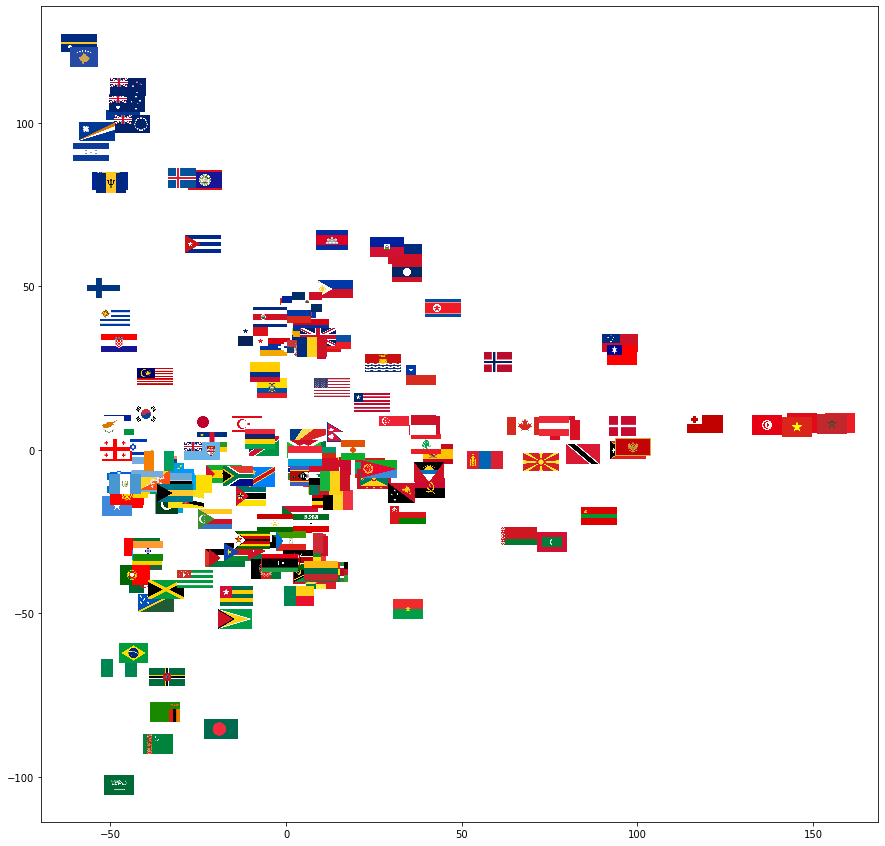

In [5]:
ih.PlotOnPlane(X_pca, fileDics.keys())

Теперь PCA

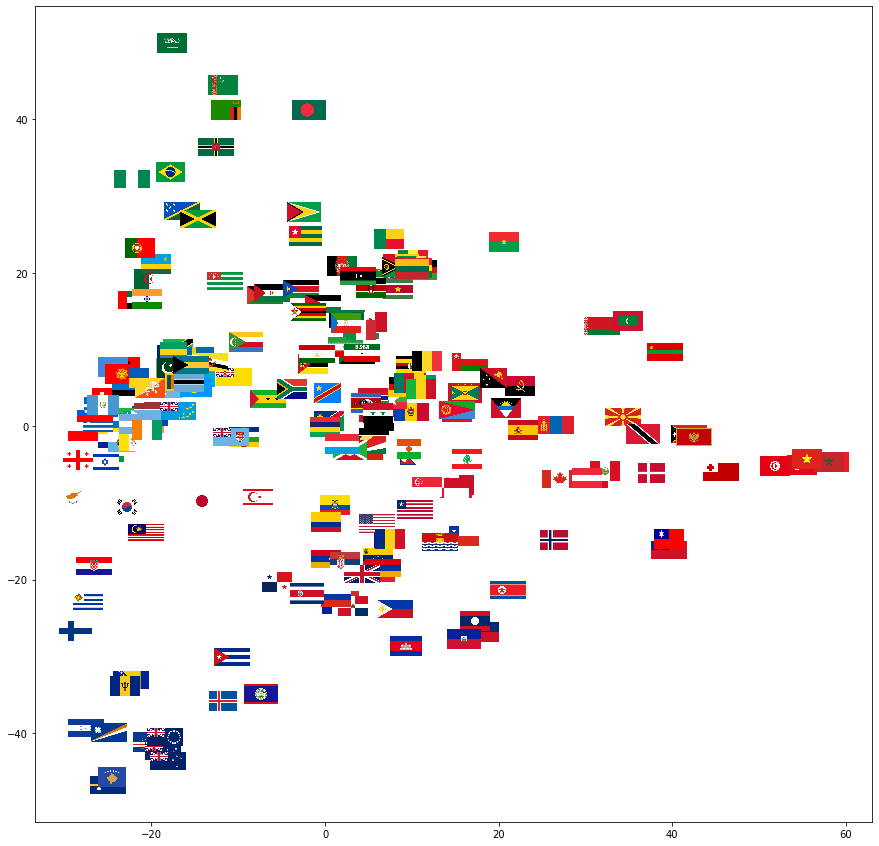

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
ih.PlotOnPlane(X_pca, fileDics.keys())

<b>Выводы:</b> оба алгоритма примерно верно распределили но у KernelPCA кучность данных получилась выше, в отличие от PCA. KernelPCA лучше откучковал явно похожие флаги, но в то же время PCA как будто лучше отделяет большое количество разноцветных похожих флагов, а у KPCA там немного хаотично получилось в области [-50,50][-50,10]